## 应用系统负载分析与磁盘容量预测
下面程序主要是通过对磁盘容量预测，预测磁盘未来的负载情况，
避免应用系统因出现存储容量耗尽的情况而导致应用系统负载过高，
最终引发系统故障

1、数据的抽取
抽取 2014-10-01 至 2014-11-16 财务系统中某一台数据库服务器的磁盘的相关数据




2、数据探索分析
本项目采用时序分析法进行建模，需要探索数据的平稳性。


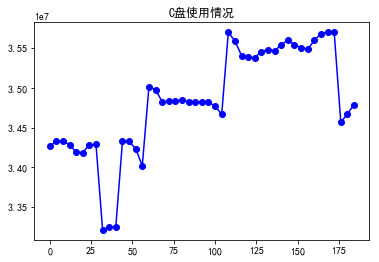

Text(0.5,1,'D盘使用情况')

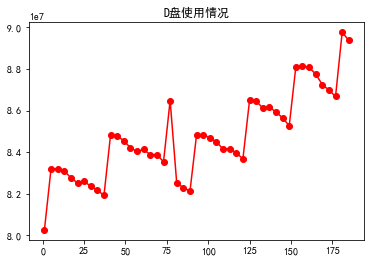

In [52]:
# 由于本案例是采用时间序列分析法进行建模的，故可以通过时序图来观测序列的平稳性

import pandas as pd
# 参数初始化
discfile = 'D:\ProgramData\python_data_analysis_and_mining_action\chapter11\data/discdata.xls'

data = pd.read_excel(discfile)

data_c=data[(data['DESCRIPTION']=='磁盘已使用大小')&(data['ENTITY']=='C:\\')]['VALUE']
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']     #正常显示中文标签
plt.plot(data_c,'b-o')
plt.title(u'C盘使用情况')
plt.show()
 
data_d=data[(data['DESCRIPTION']=='磁盘已使用大小')&(data['ENTITY']=='D:\\')][['VALUE','COLLECTTIME']]
plt.plot(data_d['VALUE'],'b-o',color='red')
plt.title(u'D盘使用情况')


3、数据的预处理
a.数据清洗
磁盘的容量在不扩充的情况下是一个固定的值，因此每天收集过来的数据，存在着大量磁盘容量的重复数据，因剔除重复的数据。
b.属性的改造
磁盘的相关属性信息以记录的形式存在数据中，其中 NAME,TARGET_ID,ENTITY 的这三个属性进行区分，这三个属性的值都是固定不变，
因此可以将这三个属性的值合并构造新的属性的值。

In [11]:
## 属性变化代码
import pandas as pd

# 参数初始化
discfile = 'D:\ProgramData\python_data_analysis_and_mining_action\chapter11\data/discdata.xls'
transformddata = 'D:\ProgramData\python_data_analysis_and_mining_action\chapter11\data\discdata_test1.xls'

data = pd.read_excel(discfile)
data = data[data['TARGET_ID']==184].copy()  # 只提取184 的数据

data_group = data.groupby('COLLECTTIME')  # 以时间分组

# 定义一个属性变换函数
def attr_trans(x):  
    result = pd.Series(index = ['SYS_NAME','CWXT_DB:184:C:\\','CWXT_DB:184:D:\\','COLLECTTIME'])
    result['SYS_NAME'] = x['SYS_NAME'].iloc[0]
    result['CWXT_DB:184:C:\\'] = x['VALUE'].iloc[0]
    result['CWXT_DB:184:D:\\'] = x['VALUE'].iloc[1]
    result['COLLECTTIME'] = x['COLLECTTIME'].iloc[0]
    return result

data_processed = data_group.apply(attr_trans) # 逐组处理
data_processed.to_excel(transformddata,index = False)

In [4]:
## 数据的平稳性检验代码
import pandas as pd 

#参数的初始化
discfile = 'D:\ProgramData\python_data_analysis_and_mining_action\chapter11\data\discdata_test1.xls'

data  = pd.read_excel(discfile)
data = data.iloc[:len(data)-5]  # 不适用最后5行

# 平稳性检测 ADF检验，即单位根检验
from statsmodels.tsa.stattools import adfuller as ADF
diff = 0
adf = ADF(data['CWXT_DB:184:D:\\'])
print(adf)
while adf[1]>=0.05: # adf[1] 为p 值，p值小于0.05认为是平稳的。
    diff = diff+1
    adf = ADF(data['CWXT_DB:184:D:\\'].diff(diff).dropna())  # 进行差分，删除缺失值  
    
print(u'原始序列经过%s阶差分后归于平稳，p值为%s'%(diff,adf[1]))


(-2.6460462274942986, 0.08384889634121945, 0, 41, {'1%': -3.60098336718852, '5%': -2.9351348158036012, '10%': -2.6059629803688282}, 958.701132117506)
0.08384889634121945
原始序列经过1阶差分后归于平稳，p值为4.79259126339371e-07


In [9]:
## 数据进行白噪声检验  为了检验序列中有用的信息是否已提取完毕，需要对数据进行白噪声检验

import pandas as pd

#参数的初始化
discfile = 'D:\ProgramData\python_data_analysis_and_mining_action\chapter11\data\discdata_test1.xls'

data  = pd.read_excel(discfile)
data = data.iloc[:len(data)-5]  # 不使用最后5行

# 白噪声检测
from statsmodels.stats.diagnostic import acorr_ljungbox

[[lb],[p]] = acorr_ljungbox(data['CWXT_DB:184:D:\\'],lags = 1)
print([[lb],[p]])
if p < 0.05:
    print(u'原始序列为非白噪声序列，对应的p值：%s'%p)
else:
    print(u'原始序列为白噪声序列，对应的p值：%s'%p)
    
[[lb],[p]] = acorr_ljungbox(data['CWXT_DB:184:D:\\'].diff().dropna(),lags = 1)
print([[lb],[p]])
if p < 0.05:
    print(u'原始序列为非白噪声序列，对应的p值：%s'%p)
else:
    print(u'原始序列为白噪声序列，对应的p值：%s'%p)


[[19.519364265098798], [9.95850372977218e-06]]
原始序列为非白噪声序列，对应的p值：9.95850372977218e-06
[[2.4933208194001515], [0.1143302597764247]]
原始序列为白噪声序列，对应的p值：0.1143302597764247


In [24]:
## 模式识别
# 采用极大似然值比方法进行模型的参数估计，估计各个参数的值。然后针对各个不同的模型，
# 采用 BIC信息准则对模型进行定阶，确定p，q 参数，从而选择最优模型。

# 确定最佳的 p,d,q 值
import pandas as pd 

# 参数的初始化
discfile = 'D:\ProgramData\python_data_analysis_and_mining_action\chapter11\data\discdata_test1.xls'

data  = pd.read_excel(discfile,index_col= 'COLLECTTIME')
data = data.iloc[:len(data)-5]  # 不使用最后5行
xdata = data['CWXT_DB:184:D:\\']

from statsmodels.tsa.arima_model import ARIMA
 # 定阶
pmax = int(len(xdata) / 10)
qmax = int(len(xdata) / 10)
# 定义bic矩阵
bic_matrix = []
for p in range(pmax + 1):
    tmp = []
    for q in range(qmax + 1):
        try:
            tmp.append(ARIMA(xdata, (p, 1, q)).fit().bic)
        except:
            tmp.append(None)
    bic_matrix.append(tmp)
bic_matrix = pd.DataFrame(bic_matrix)
# print(bic_matrix.stack())
# 找出最小值
p, q = bic_matrix.stack().astype('float64').idxmin()
print(u"BIC最小的p值和q值为：%s、%s" % (p, q))

COLLECTTIME
2014-10-01    80262592.65
2014-10-02    83200151.65
2014-10-03    83208320.00
2014-10-04    83099271.65
2014-10-05    82765171.65
2014-10-06    82522895.00
2014-10-07    82590885.00
2014-10-08    82368173.30
2014-10-09    82172263.30
2014-10-10    81922685.00
2014-10-11    84844722.95
2014-10-12    84769868.90
2014-10-13    84558703.40
2014-10-14    84207166.80
2014-10-15    84042911.90
2014-10-16    84129516.15
2014-10-17    83877754.85
2014-10-18    83887520.40
2014-10-19    83538509.75
2014-10-20    86483653.00
2014-10-21    82496743.30
2014-10-22    82300356.65
2014-10-23    82130251.65
2014-10-24    84844587.65
2014-10-25    84845444.65
2014-10-26    84684911.05
2014-10-27    84500606.35
2014-10-28    84145461.25
2014-10-29    84172525.10
2014-10-30    83957818.70
2014-10-31    83684789.75
2014-11-01    86485366.95
2014-11-02    86454023.45
2014-11-03    86127041.70
2014-11-04    86161390.40
2014-11-05    85938933.90
2014-11-06    85645056.50
2014-11-07    85272926.05


D:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
D:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
D:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
D:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signa

0  0    1275.69
   1    1273.19
   2    1274.33
   3    1274.46
1  0    1276.75
   1    1271.89
2  0    1279.69
   1    1275.51
   3    1279.14
3  0    1278.07
   1    1278.99
   2    1282.78
   3    1285.94
4  0    1281.22
   1     1282.7
   2     1286.3
   3     1290.2
dtype: object
BIC最小的p值和q值为：1、1


In [27]:
## 模型的检验
##模型确定以后，检验其残差序列是否为白噪声
# 确定模型后，需要检验其残差序列是否是白噪声，若不是，
# 说明，残差中还存在有用的信息，需要修改模型或者进一步提取。若其残差不是白噪声，重新更换p,q的值，重新确定
import pandas as pd 

# 参数的初始化
discfile = 'D:\ProgramData\python_data_analysis_and_mining_action\chapter11\data\discdata_test1.xls'

data  = pd.read_excel(discfile,index_col= 'COLLECTTIME')
data = data.iloc[:len(data)-5]  # 不使用最后5行
xdata = data['CWXT_DB:184:D:\\']

lagnum = 12 #残差延迟个数

from statsmodels.tsa.arima_model import ARIMA

arima = ARIMA(xdata,(p,1,q)).fit() # 建立训练模型
xdata_pred = arima.predict(typ = 'levels') # 预测
perd_error = (xdata_pred - xdata).dropna() # 计算残差

from statsmodels.stats.diagnostic import acorr_ljungbox   # 白噪声检测

lb,p_l = acorr_ljungbox(perd_error,lags = lagnum)
h = (p_l < 0.05).sum() #p值小于0.05，认为是非白噪声。
if h > 0:
    print (u'模型ARIMA(%s,1,%s)不符合白噪声检验'%(p,q))
else:
    print (u'模型ARIMA(%s,1,%s)符合白噪声检验' %(p,q))


D:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


模型ARIMA(1,1,1)符合白噪声检验


In [44]:
## 模型的预测
## 通过对模型的预测，获取5天的预测值，并且与实际值作比较，也就是我忽略的5条数据

import pandas as pd 

# 参数的初始化
discfile = 'D:\ProgramData\python_data_analysis_and_mining_action\chapter11\data\discdata_test1.xls'

data  = pd.read_excel(discfile,index_col= 'COLLECTTIME')

test_predict = arima.forecast(5)[0]
print(test_predict)

# 预测对比
test_data=pd.DataFrame(columns=[u'实际容量',u'预测容量'])
test_data[u'实际容量']=data[(len(data)-5):]['CWXT_DB:184:D:\\']
test_data[u'预测容量']=test_predict
test_data = test_data.applymap(lambda x: '%.2f' % x)

test_data.to_excel('D:\ProgramData\python_data_analysis_and_mining_action\chapter11\data\predict_data.xlsx')



[87371577.14273813 87288785.3646306  87328125.8433352  87417327.27063102
 87526884.61584161]


In [49]:
## 模型的评价
# 评价一个模型的好坏 从三个统一计量指标：平均绝对误差，均方根误差和平方绝对百分误差。
import pandas as pd

file = 'D:\ProgramData\python_data_analysis_and_mining_action\chapter11\data\predict_data.xlsx'
result = pd.read_excel(file,index_col='COLLECTTIME')
result = result.applymap(lambda x: x/10**6)
print(result)

# 计算误差
abs_ = (result[u'预测容量']- result[u'实际容量']).abs()
mae_ = abs_.mean() # mae平均绝对误差
rmas_ = ((abs_**2).mean())**0.5 #rmas均方根误差
mape_ = (abs_/result[u'实际容量']).mean() #mape平均绝对百分误差


print(abs_)  
print(mae_) 
print(rmas_ ) 
print(mape_)
errors = 1.5  
print ('误差阈值为%s' % errors ) 
if (mae_ < errors) & (rmas_ < errors) & (mape_ < errors):  
    print (u'平均绝对误差为：%.4f, \n均方根误差为：%.4f, \n平均绝对百分误差为：%.4f' % (mae_, rmas_, mape_))  
    print ('误差检验通过！')
else:  
    print ('误差检验不通过！') 
    
    
    
# 根据输出结果 该模型的产生的误差在范围之内可以采用该模型进行预测

                  实际容量       预测容量
COLLECTTIME                      
2014-11-12   87.249336  87.371577
2014-11-13   86.986142  87.288785
2014-11-14   86.678240  87.328126
2014-11-15   89.766600  87.417327
2014-11-16   89.377527  87.526885
COLLECTTIME
2014-11-12    0.122242
2014-11-13    0.302643
2014-11-14    0.649886
2014-11-15    2.349273
2014-11-16    1.850643
dtype: float64
1.0549371899999982
1.376433652418303
0.011850951763401518
误差阈值为1.5
平均绝对误差为：1.0549, 
均方根误差为：1.3764, 
平均绝对百分误差为：0.0119
误差检验通过！
